In [57]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
results_fp = "/Users/rt582/Desktop/results_summary.csv"

import ast  # To convert string representations of lists to actual lists

# Define custom converters for list columns
def list_converter(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except (ValueError, SyntaxError):
        return val

# Load CSV with correct data types
results_df = pd.read_csv(results_fp, 
                 header=[0,1],
                 parse_dates=[('metadata','datetime (UTC)')],  # Assuming 'metadata' is a datetime column in the multi-index
                 converters={
                     ('processing', 'nir_wavelengths'): list_converter,
                     ('processing', 'sensor_range'): list_converter,
                     ('processing', 'endmember_bounds'): list_converter,
                     ('processing', 'endmember_dimensionality_reduction'): list_converter,
                     ('fitting', 'bb_bounds'): list_converter,
                     ('fitting', 'Kd_bounds'): list_converter,
                     ('fitting', 'H_bounds'): list_converter,
                    ('simulation', 'Rb_vals'): list_converter,
                    ('simulation', 'depth_lims'): list_converter,
                    ('simulation', 'k_lims'): list_converter,
                    ('simulation', 'bb_lims'): list_converter,
                    ('simulation', 'noise_lims'): list_converter,
                     ('processing', 'endmember_source'): lambda x: x if x != 'None' else None,  # Convert 'None' strings to None
                     ('processing', 'save_fits'): lambda x: x == 'True',  # Convert to boolean
                 }
)

In [26]:
results_df.columns

MultiIndex([(            'metadata',                     'datetime (UTC)'),
            ('global_configuration',                     'spectra_source'),
            ('global_configuration',                         'spectra_fp'),
            ('global_configuration',                'spectral_library_fp'),
            ('global_configuration',                 'validation_data_fp'),
            ('global_configuration',                          'save_fits'),
            (          'processing',                   'endmember_source'),
            (          'processing',                      'aop_group_num'),
            (          'processing',                    'nir_wavelengths'),
            (          'processing',                       'sensor_range'),
            (          'processing', 'endmember_dimensionality_reduction'),
            (          'processing',            'endmember_normalisation'),
            (          'processing',             'endmember_class_schema'),
            

In [74]:
sub_df = results_df[results_df['fitting']['objective_fn'] == 'r2']
best_row = sub_df.loc[sub_df['r2', 'mean'].idxmax()]
best_row.r2

# Initialize the dictionary
best_cfg_params_dict = {
    'processing': {},
    'simulation': {},
    'fitting': {}
}

for (level_0, level_1) in best_row.index:
    value = best_row[(level_0, level_1)]
    if level_0 in best_cfg_params_dict:
        if not isinstance(value, list):
            value = None if pd.isna(value) else value
            
        best_cfg_params_dict[level_0][level_1] = value
# best_cfg_params_dict

In [75]:
# run pipeline with cfg
g_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
cfg = file_ops.RunOptPipeConfig(best_cfg_params_dict)

pipe = optimisation_pipeline.OptPipe(g_cfg, cfg)
fit_results = pipe.run()

Fitting spectra:   0%|          | 0/1938 [00:00<?, ?it/s]

RunOptPipeConfig(processing={'endmember_source': 'spectral_library', 'aop_group_num': 1, 'nir_wavelengths': [750, 1100], 'sensor_range': [450, 690], 'endmember_dimensionality_reduction': ['pca', 1], 'endmember_normalisation': None, 'endmember_class_schema': 'three_endmember', 'spectra_normalisation': None}, fitting={'Rb_init': 0.5, 'endmember_bounds': '[0, 1]', 'objective_fn': 'r2', 'bb_bounds': (0, 0.41123), 'Kd_bounds': (0.01688, 1.5), 'H_bounds': (0, 10), 'solver': 'CG', 'tol': 1e-12}, simulation={'type': 'spread', 'N': 100, 'Rb_vals': (0, 1), 'n_depths': 10, 'depth_lims': (0, 10), 'n_ks': 10, 'k_lims': (0, 0.4), 'n_bbs': 10, 'bb_lims': (0.01, 0.03), 'n_noise_levels': 10, 'noise_lims': (0.001, 0), 'noise_ind': 0}, aop_group_num=1, nir_wavelengths=[750, 1100], sensor_range=[450, 690], endmember_source='spectral_library', endmember_dimensionality_reduction=['pca', 1], endmember_normalisation=None, endmember_class_schema='three_endmember', spectra_normalisation=None, objective_fn='r2',

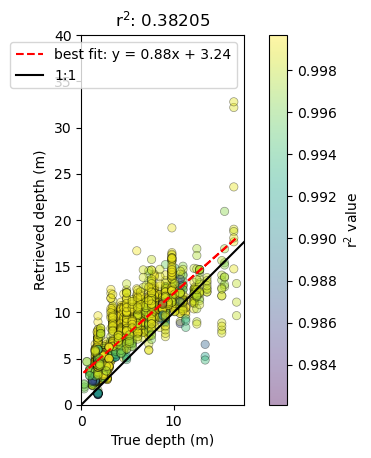

In [76]:
from sklearn.metrics import r2_score
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data_v2.csv")


fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth[:len(fit_results)], fit_results.fitted_params["H"], alpha=0.4, c=fit_results.metrics.r2, edgecolor='k', lw=0.5)

# calculate fit_results
p = np.polyfit(validation_data.Depth[:len(fit_results)], fit_results.fitted_params["H"].astype(float), 1)
pred = np.polyval(p, validation_data.Depth[:len(fit_results)])
r2 = r2_score(validation_data.Depth[:len(fit_results)], pred)
ax.plot(validation_data.Depth[:len(fit_results)], pred, color='r', ls='--', label="best fit: y = {:.2f}x + {:.2f}".format(*p))
# formatting
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=40)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_aspect('equal')
fig.colorbar(ma, label="r$^2$ value")
ax.legend()

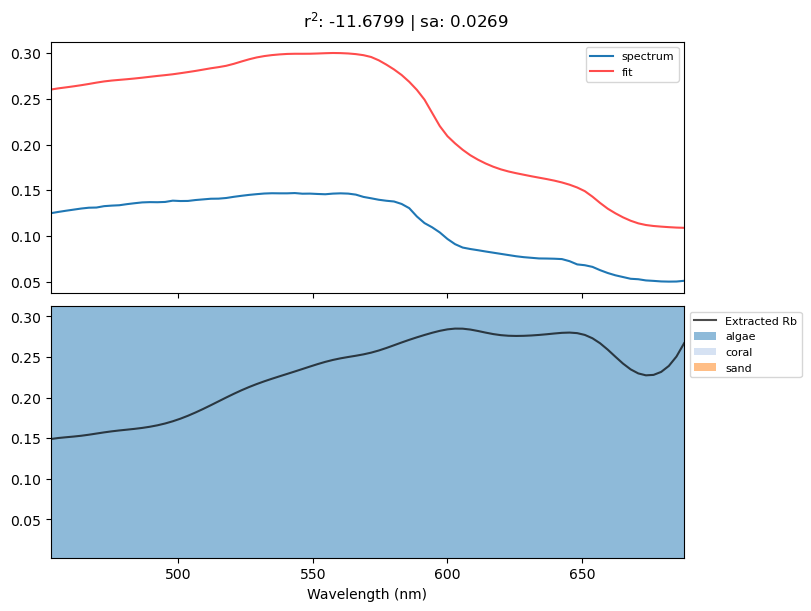

In [70]:
i = 0

fits = fit_results

AOP_model = spectrum_utils.load_aop_model(aop_group_num=1).loc[spectrum_utils.SENSOR_RANGE[0]:spectrum_utils.SENSOR_RANGE[1]]
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

# generate endmembers
endmember_class_schema = best_row.processing["endmember_class_schema"]
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
# generate endmember array
endmember_array = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map=glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction="mean",
).generate_endmembers()
# crop to sensor range
endmember_array = endmember_array.loc[:,spectrum_utils.SENSOR_RANGE[0]:spectrum_utils.SENSOR_RANGE[1]]

prism_spectra = spectrum_utils.crop_spectra_to_range(spectrum_utils.load_spectra(), [min(wvs), max(wvs)])
fit = fits.iloc[i,:3+len(endmember_array)]
true_spectrum = prism_spectra.iloc[i,:]
# plot problem fits
plotting.plot_single_fit(fit, true_spectrum, AOP_args, endmember_array, endmember_array.index)